In [1]:
import numpy, pandas, emat
from matplotlib import pyplot as plt

/Users/jpn/anaconda/envs/EMAT-DEV/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
logger = emat.util.loggers.log_to_stderr(20, True)

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [4]:
def core1(x1=0, x2=0):
    return numpy.sin(x1) + x1 + numpy.cos(x1*17)/10 + numpy.sin(x2*13)/12

In [5]:
def core2(x1=0, x2=0):
    x3 = x1 + x2*.25
    return numpy.sin(x3) + numpy.sin(x3*3)/3 + numpy.sin(x3*5)/5 + numpy.sin(x3*7)/7 + numpy.sin(x3*9)/9 + numpy.cos(x2)*4

In [6]:
def core3(x1=0, x2=0):
    takeup = 1-(1/(numpy.exp((x1-3)*5+numpy.cos(x2)-x2)+1))
    decay = numpy.fmax((1/(numpy.exp((x1-x2-4+numpy.sin(x2))/3)+1)), 0.25)
    takeup2 = 1-(1/(numpy.exp((x1-9)*9+numpy.cos(x2*2)+x2*3)+1))

    return decay*takeup+takeup2

In [7]:
grid = numpy.meshgrid(numpy.linspace(0,12,100), numpy.linspace(0,10,100))
grid_df = pandas.DataFrame.from_dict(dict(x1=grid[0].ravel(), x2=grid[1].ravel()))

In [8]:
grid_df['Cc'] = grid_df.apply(lambda x: core3(**x), axis=1)

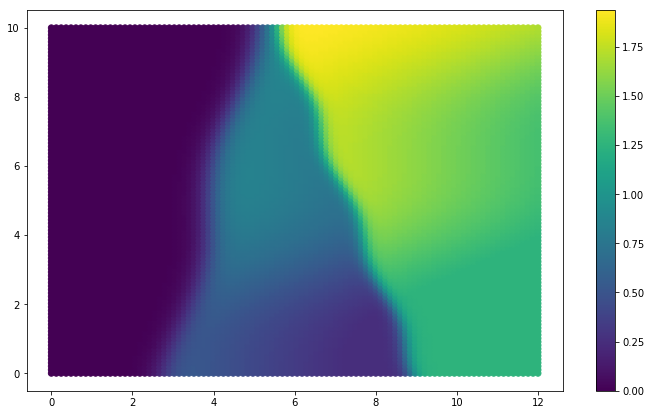

In [9]:
plt.figure(figsize=(12,7))
scat = plt.scatter(grid_df.x1, grid_df.x2, c=grid_df.Cc)
plt.colorbar(scat)

In [10]:
def core_f(x1,x2):
    return {'Aa':core1(x1, x2), 'Bb':core3(x1, x2),}

In [11]:
a = numpy.linspace(0,12,1000)

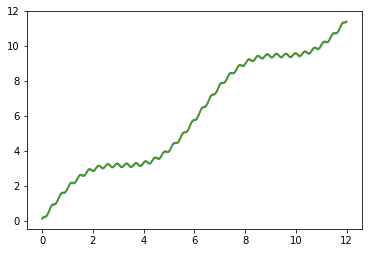

In [12]:
plt.plot(a, core1(a,0));
plt.plot(a, core1(a,1));
plt.plot(a, core1(a,3.1));

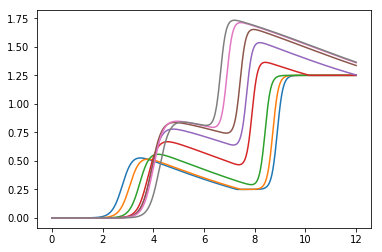

In [13]:
plt.plot(a, core3(a,0));
plt.plot(a, core3(a,1));
plt.plot(a, core3(a,2));
plt.plot(a, core3(a,3));
plt.plot(a, core3(a,4));
plt.plot(a, core3(a,5));
plt.plot(a, core3(a,6));
plt.plot(a, core3(a,7));

In [14]:
scope_def="""---
scope:
    name: simplistic
inputs:
    x1:
        ptype: exogenous uncertainty
        default: 0
        min: 0.0
        max: 12.0
        dist:
            name: pert
            peak: 3
            gamma: 4
    x2:
        ptype: policy lever
        default: 1.0
        min: 0.0
        max: 10.0
outputs:
    Aa:
        kind: minimize
    Bb:
        kind: maximize
...
"""

In [15]:
s = emat.Scope(scope_file="/tmp/simple-scope.yaml", scope_def=scope_def)

In [16]:
db = emat.SQLiteDB()

[00:05.93] MainProcess/INFO: running script scope.sql
[00:05.93] MainProcess/INFO: running script exp_design.sql
[00:05.94] MainProcess/INFO: running script meta_model.sql


In [17]:
s.store_scope(db)

In [18]:
from emat.experiment.experimental_design import design_experiments
design = design_experiments(s, n_samples_per_factor=10, sampler='lhs', db=db, random_seed=1)
design

,x1,x2
experiment,,
1,1.924869,2.611062
2,5.978216,7.036682
3,2.867495,9.234619
4,3.773829,3.548086
5,1.590173,6.451685
6,5.220641,4.559745
7,2.193670,1.262400
8,6.463013,6.541812
9,2.958569,8.458431


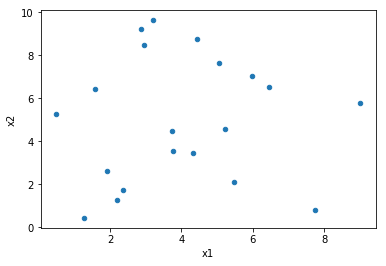

In [19]:
design.plot.scatter('x1','x2')

In [20]:
from emat.model.core_python import PythonCoreModel
m = PythonCoreModel(core_f, scope=s, db=db)

In [21]:
m

<emat.PythonCoreModel "EMAT", metamodel_id=None with 1 uncertainties, 1 levers, 2 measures>

In [22]:
from ema_workbench import SequentialEvaluator

In [23]:
with SequentialEvaluator(m) as eval_seq:
    lhs_results = m.run_experiments(design_name='lhs', evaluator=eval_seq)
lhs_results.head()

[00:06.10] MainProcess/INFO: performing 20 scenarios/policies * 1 model(s) = 20 experiments
[00:06.10] MainProcess/INFO: performing experiments sequentially
[00:06.11] MainProcess/INFO: 2 cases completed
[00:06.11] MainProcess/INFO: 4 cases completed
[00:06.11] MainProcess/INFO: 6 cases completed
[00:06.11] MainProcess/INFO: 8 cases completed
[00:06.11] MainProcess/INFO: 10 cases completed
[00:06.11] MainProcess/INFO: 12 cases completed
[00:06.11] MainProcess/INFO: 14 cases completed
[00:06.11] MainProcess/INFO: 16 cases completed
[00:06.11] MainProcess/INFO: 18 cases completed
[00:06.12] MainProcess/INFO: 20 cases completed
[00:06.12] MainProcess/INFO: experiments finished


,x1,x2,Aa,Bb
experiment,,,,
1,1.924869,2.611062,2.936919,0.000115
2,5.978216,7.036682,5.693240,0.813507
3,2.867495,9.234619,3.195162,0.000018
4,3.773829,3.548086,3.277450,0.284145
5,1.590173,6.451685,2.625475,0.000003


In [24]:
lhs_results

,x1,x2,Aa,Bb
experiment,,,,
1,1.924869,2.611062,2.936919,1.149371e-04
2,5.978216,7.036682,5.693240,8.135071e-01
3,2.867495,9.234619,3.195162,1.823438e-05
4,3.773829,3.548086,3.277450,2.841445e-01
5,1.590173,6.451685,2.625475,3.479382e-06
6,5.220641,4.559745,4.451182,8.074870e-01
7,2.193670,1.262400,3.043827,4.522328e-03
8,6.463013,6.541812,6.523999,8.694827e-01
9,2.958569,8.458431,3.240206,9.253221e-05


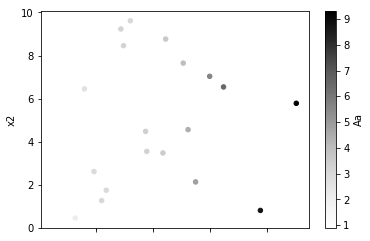

In [25]:
lhs_results.plot.scatter('x1','x2',c='Aa');

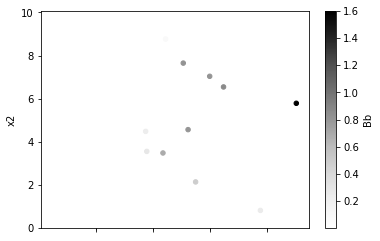

In [26]:
lhs_results.plot.scatter('x1','x2',c='Bb');

In [27]:
mm = m.create_metamodel_from_design('lhs')
mm

<emat.PythonCoreModel "EMATMeta", metamodel_id=1 with 1 uncertainties, 1 levers, 2 measures>

In [28]:
cv_initial = mm.function.cross_val_scores()

In [29]:
cv_initial

Aa    0.889948
Bb    0.544100
dtype: float64

In [30]:
dict(1-cv_initial)

{'Aa': 0.11005249752275237, 'Bb': 0.4558999709125706}

In [31]:

        
from emat.experiment.experimental_design import minimum_weighted_distance, batch_pick_new_experiments
    

In [32]:
n_augmentations = 4
batch_size = 8

In [33]:
aug_design = {}
aug_results = {}
design_names = ['lhs',]
aug_mm = {-1: mm}
aug_cv = {-1: cv_initial}

In [34]:
future_exper = design_experiments(s, n_samples=1000, sampler='lhs', random_seed=124)

In [35]:
future_exper.head()

,x1,x2
0,1.192078,2.212413
1,5.785421,2.942410
2,6.607914,5.476999
3,3.878492,5.565825
4,5.828658,0.481445


In [38]:
# future_exper.apply(
#         lambda x: pandas.Series(aug_mm[aug-1].function.compute_std(**x)), 
#         axis=1,
#     )

[00:35.34] MainProcess/INFO: Selecting 1581
[00:35.41] MainProcess/INFO: Selecting 3106
[00:35.49] MainProcess/INFO: Selecting 3301
[00:35.56] MainProcess/INFO: Selecting 3768
[00:35.62] MainProcess/INFO: Selecting 3572
[00:35.69] MainProcess/INFO: Selecting 3766
[00:35.76] MainProcess/INFO: Selecting 528
[00:35.82] MainProcess/INFO: Selecting 3275
[00:35.93] MainProcess/INFO: Replacing 1581 with 526
[00:36.22] MainProcess/INFO: Replacing 3766 with 2822
[00:36.35] MainProcess/INFO: 2 Fedorov Exchanges completed.
[00:36.81] MainProcess/INFO: 0 Fedorov Exchanges completed.
[00:36.81] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[00:36.82] MainProcess/INFO: performing experiments sequentially
[00:36.82] MainProcess/INFO: 1 cases completed
[00:36.82] MainProcess/INFO: 2 cases completed
[00:36.82] MainProcess/INFO: 3 cases completed
[00:36.82] MainProcess/INFO: 4 cases completed
[00:36.82] MainProcess/INFO: 5 cases completed
[00:36.83] MainProcess/INFO: 6 c

Aa    0.994024
Bb    0.766212
dtype: float64
------- 1


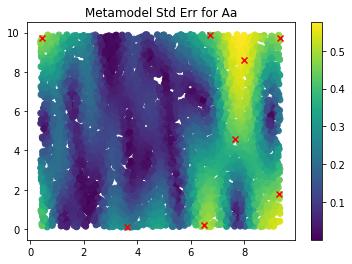

------- 2


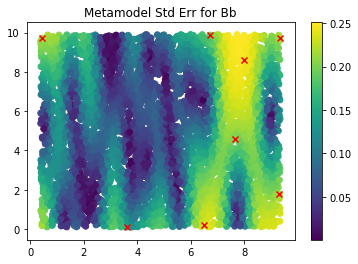

------- 3


[01:07.52] MainProcess/INFO: Selecting 630
[01:07.59] MainProcess/INFO: Selecting 497
[01:07.65] MainProcess/INFO: Selecting 4804
[01:07.72] MainProcess/INFO: Selecting 3210
[01:07.78] MainProcess/INFO: Selecting 1138
[01:07.85] MainProcess/INFO: Selecting 378
[01:07.92] MainProcess/INFO: Selecting 2585
[01:07.98] MainProcess/INFO: Selecting 1029
[01:08.46] MainProcess/INFO: 0 Fedorov Exchanges completed.
[01:08.46] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[01:08.47] MainProcess/INFO: performing experiments sequentially
[01:08.47] MainProcess/INFO: 1 cases completed
[01:08.47] MainProcess/INFO: 2 cases completed
[01:08.47] MainProcess/INFO: 3 cases completed
[01:08.47] MainProcess/INFO: 4 cases completed
[01:08.47] MainProcess/INFO: 5 cases completed
[01:08.47] MainProcess/INFO: 6 cases completed
[01:08.48] MainProcess/INFO: 7 cases completed
[01:08.48] MainProcess/INFO: 8 cases completed
[01:08.48] MainProcess/INFO: experiments finished


Aa    0.995066
Bb    0.799905
dtype: float64
------- 1


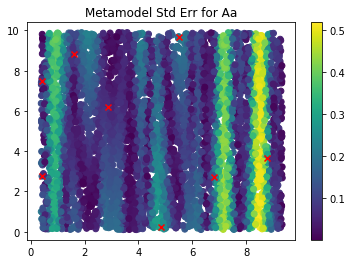

------- 2


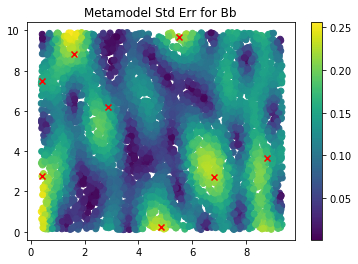

------- 3


[01:40.54] MainProcess/INFO: Selecting 1929
[01:40.61] MainProcess/INFO: Selecting 3074
[01:40.67] MainProcess/INFO: Selecting 63
[01:40.74] MainProcess/INFO: Selecting 3176
[01:40.81] MainProcess/INFO: Selecting 3040
[01:40.88] MainProcess/INFO: Selecting 391
[01:40.94] MainProcess/INFO: Selecting 965
[01:41.01] MainProcess/INFO: Selecting 3910
[01:41.48] MainProcess/INFO: 0 Fedorov Exchanges completed.
[01:41.49] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[01:41.50] MainProcess/INFO: performing experiments sequentially
[01:41.50] MainProcess/INFO: 1 cases completed
[01:41.50] MainProcess/INFO: 2 cases completed
[01:41.50] MainProcess/INFO: 3 cases completed
[01:41.50] MainProcess/INFO: 4 cases completed
[01:41.50] MainProcess/INFO: 5 cases completed
[01:41.50] MainProcess/INFO: 6 cases completed
[01:41.50] MainProcess/INFO: 7 cases completed
[01:41.50] MainProcess/INFO: 8 cases completed
[01:41.50] MainProcess/INFO: experiments finished


Aa    0.994209
Bb    0.876800
dtype: float64
------- 1


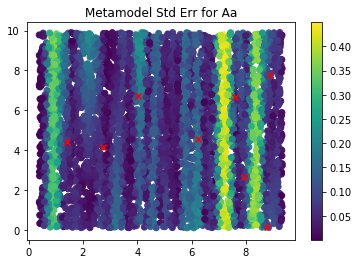

------- 2


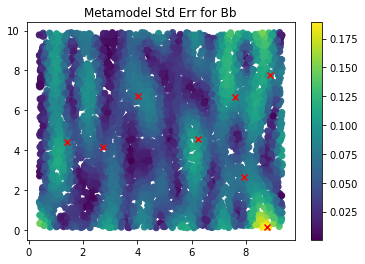

------- 3


[02:11.76] MainProcess/INFO: Selecting 2989
[02:11.83] MainProcess/INFO: Selecting 2472
[02:11.89] MainProcess/INFO: Selecting 1920
[02:11.96] MainProcess/INFO: Selecting 1386
[02:12.02] MainProcess/INFO: Selecting 1281
[02:12.09] MainProcess/INFO: Selecting 463
[02:12.16] MainProcess/INFO: Selecting 1452
[02:12.22] MainProcess/INFO: Selecting 3638
[02:12.33] MainProcess/INFO: Replacing 2989 with 2793
[02:12.40] MainProcess/INFO: Replacing 2472 with 3132
[02:12.77] MainProcess/INFO: 2 Fedorov Exchanges completed.
[02:13.22] MainProcess/INFO: 0 Fedorov Exchanges completed.
[02:13.23] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[02:13.24] MainProcess/INFO: performing experiments sequentially
[02:13.24] MainProcess/INFO: 1 cases completed
[02:13.24] MainProcess/INFO: 2 cases completed
[02:13.24] MainProcess/INFO: 3 cases completed
[02:13.24] MainProcess/INFO: 4 cases completed
[02:13.24] MainProcess/INFO: 5 cases completed
[02:13.24] MainProcess/INFO: 6 

Aa    0.993250
Bb    0.941172
dtype: float64
------- 1


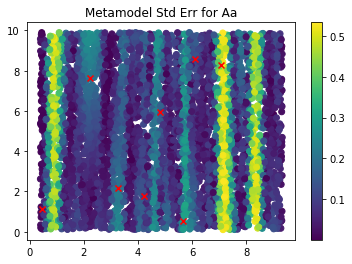

------- 2


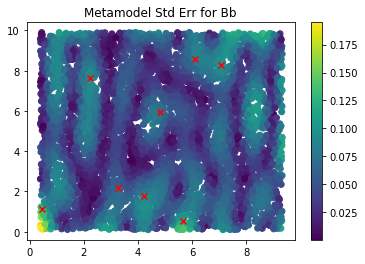

------- 3


<Figure size 432x288 with 0 Axes>

In [39]:
for aug in range(n_augmentations):
    design_pool = design_experiments(s, n_samples=5000, sampler='ulhs98', random_seed=42+aug)
    
    future_exper_std = future_exper.apply(
        lambda x: pandas.Series(aug_mm[aug-1].function.compute_std(**x)), 
        axis=1,
    )
    
    aug_design[aug] = aug_mm[aug-1].function.pick_new_experiments(
            design_pool,
            batch_size=batch_size,
            output_focus=dict(1-aug_cv[aug-1]),
            scope=s,
            db=db,
            design_name=f'aug_{aug}',
#             debug=('x1','x2'),
#             future_experiments=future_exper,
#             future_experiments_std=future_exper_std,
    )
    with SequentialEvaluator(m) as eval_seq:
        aug_results[aug] = m.run_experiments(design_name=f'aug_{aug}', evaluator=eval_seq)
    design_names.append(f'aug_{aug}')
    aug_mm[aug] = m.create_metamodel_from_designs(design_names)
    aug_cv[aug] = aug_mm[aug].function.cross_val_scores()
    print(aug_cv[aug])
    
    # Show STDERR from Metamodels
    design_pool[['std_Aa', 'std_Bb']] = design_pool[['x1','x2']].apply(
        lambda x: pandas.Series(aug_mm[aug-1].function.compute_std(**x)), 
        axis=1,
    )

    print("------- 1")

    plt.clf()
    #plt.figure(figsize=(12,7))
    scat = plt.scatter(design_pool.x1, design_pool.x2, c=design_pool.std_Aa)
    plt.colorbar(scat)
    plt.scatter(aug_design[aug].x1, aug_design[aug].x2, color="red", marker='x')
    plt.title("Metamodel Std Err for Aa");
    plt.show()
    
    print("------- 2")
    
    plt.clf()
    #plt.figure(figsize=(12,7))
    scat = plt.scatter(design_pool.x1, design_pool.x2, c=design_pool.std_Bb)
    plt.colorbar(scat)
    plt.scatter(aug_design[aug].x1, aug_design[aug].x2, color="red", marker='x')
    plt.title("Metamodel Std Err for Bb");
    plt.show()
    
    plt.clf()
    print("------- 3")


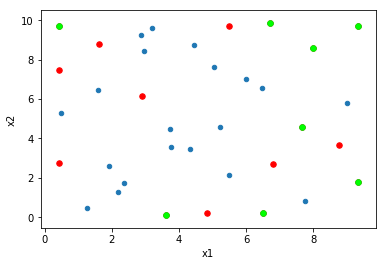

In [40]:
ax = design.plot.scatter('x1','x2')
ax = aug_design[0].plot.scatter('x1','x2', ax=ax, c='#A00000', s=30)
ax = aug_design[1].plot.scatter('x1','x2', ax=ax, c='#FF0000', s=30)
ax = aug_design[0].plot.scatter('x1','x2', ax=ax, c='#00FF00', s=30)



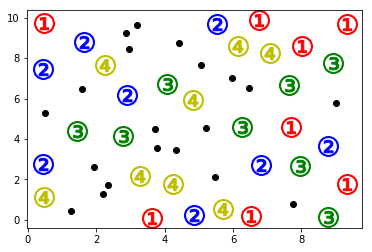

In [41]:
plt.plot(design.x1, design.x2, 'ko')
plt.plot(aug_design[0].x1, aug_design[0].x2, "ro", marker=r'$①$', markersize=22)
plt.plot(aug_design[1].x1, aug_design[1].x2, "bo", marker=r'$②$', markersize=22)
plt.plot(aug_design[2].x1, aug_design[2].x2, "go", marker=r'$③$', markersize=22)
plt.plot(aug_design[3].x1, aug_design[3].x2, "yo", marker=r'$④$', markersize=22)

In [42]:
# TEST

In [43]:
testdesign = design_experiments(s, n_samples=10000, sampler='lhs', random_seed=123)

In [44]:
testresults_core = m.run_experiments(design=testdesign, db=False)
testresults_core.head()

[02:40.83] MainProcess/INFO: performing 10000 scenarios/policies * 1 model(s) = 10000 experiments
[02:40.83] MainProcess/INFO: performing experiments sequentially
[02:41.01] MainProcess/INFO: 1000 cases completed
[02:41.19] MainProcess/INFO: 2000 cases completed
[02:41.37] MainProcess/INFO: 3000 cases completed
[02:41.55] MainProcess/INFO: 4000 cases completed
[02:41.74] MainProcess/INFO: 5000 cases completed
[02:41.92] MainProcess/INFO: 6000 cases completed
[02:42.10] MainProcess/INFO: 7000 cases completed
[02:42.29] MainProcess/INFO: 8000 cases completed
[02:42.47] MainProcess/INFO: 9000 cases completed
[02:42.64] MainProcess/INFO: 10000 cases completed
[02:42.64] MainProcess/INFO: experiments finished


,x1,x2,Aa,Bb
0,2.417055,1.302828,2.904427,1.233731e-02
1,0.862176,1.589445,1.652660,3.541976e-06
2,7.900325,6.559052,8.792522,1.688976e+00
3,0.736626,5.090140,1.491900,1.036250e-07
4,3.283173,6.701449,3.153893,1.137273e-02


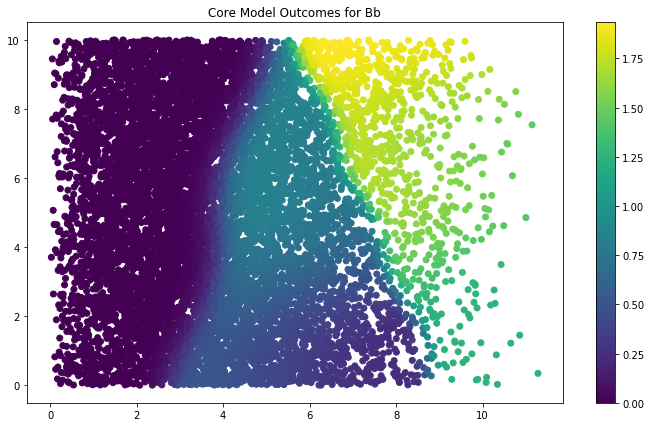

In [45]:
plt.figure(figsize=(12,7))
scat = plt.scatter(testresults_core.x1, testresults_core.x2, c=testresults_core.Bb)
plt.colorbar(scat)
plt.title("Core Model Outcomes for Bb");

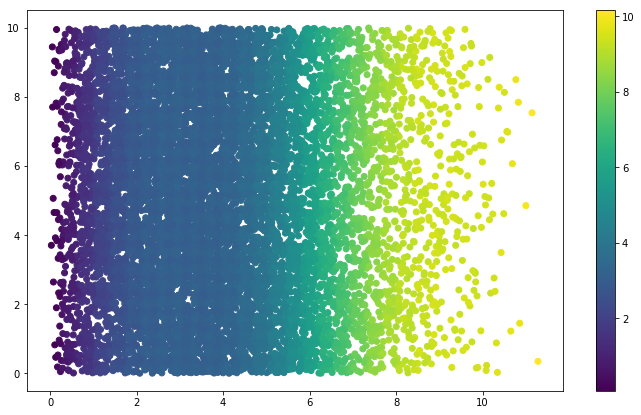

In [46]:
plt.figure(figsize=(12,7))
scat = plt.scatter(testresults_core.x1, testresults_core.x2, c=testresults_core.Aa)
plt.colorbar(scat)

In [47]:
testresults_3 = aug_mm[3].run_experiments(design=testdesign, db=False)
testresults_3.head()

[02:44.09] MainProcess/INFO: performing 10000 scenarios/policies * 1 model(s) = 10000 experiments
[02:44.10] MainProcess/INFO: performing experiments sequentially
[02:47.58] MainProcess/INFO: 1000 cases completed
[02:51.01] MainProcess/INFO: 2000 cases completed
[02:54.46] MainProcess/INFO: 3000 cases completed
[02:57.90] MainProcess/INFO: 4000 cases completed
[03:01.46] MainProcess/INFO: 5000 cases completed
[03:04.97] MainProcess/INFO: 6000 cases completed
[03:08.33] MainProcess/INFO: 7000 cases completed
[03:11.80] MainProcess/INFO: 8000 cases completed
[03:15.21] MainProcess/INFO: 9000 cases completed
[03:18.58] MainProcess/INFO: 10000 cases completed
[03:18.58] MainProcess/INFO: experiments finished


,x1,x2,Aa,Bb
0,2.417055,1.302828,2.914897,0.031765
1,0.862176,1.589445,1.515973,0.054896
2,7.900325,6.559052,8.808648,1.734153
3,0.736626,5.090140,1.146700,0.001439
4,3.283173,6.701449,2.982961,0.026668


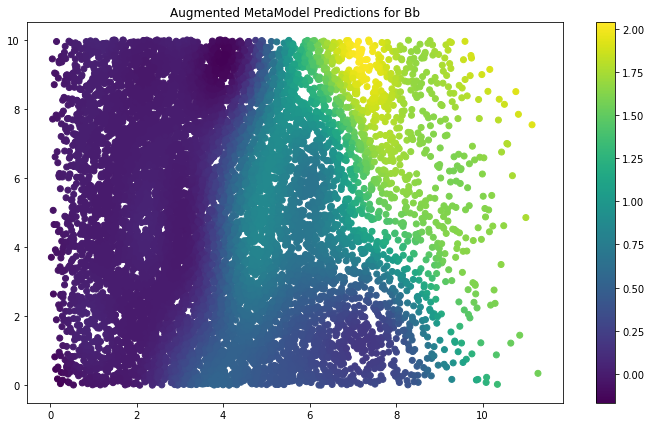

In [48]:
plt.figure(figsize=(12,7))
scat = plt.scatter(testresults_3.x1, testresults_3.x2, c=testresults_3.Bb)
plt.colorbar(scat)
plt.title("Augmented MetaModel Predictions for Bb");

In [49]:
testresults_3['BbZ'] = testresults_core.Bb

In [50]:
aug_mm[3].function(x1=1.312643, x2=9.547349)

{'Aa': 2.3814961930373384, 'Bb': 0.0319202677390516}

In [51]:
m.function(x1=1.312643, x2=9.547349)

{'Aa': 2.101390191857003, 'Bb': 5.643498189704248e-09}

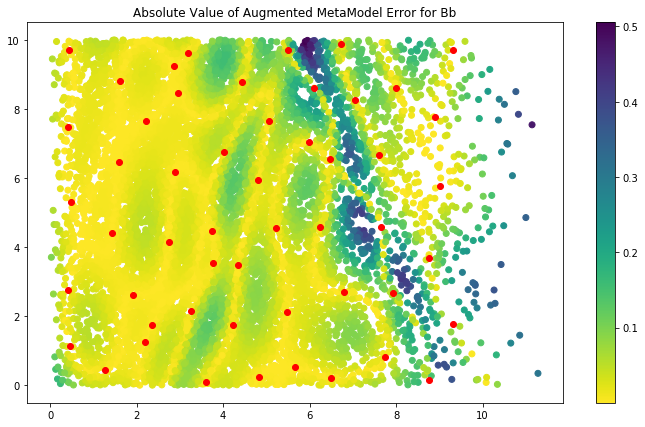

In [52]:
plt.figure(figsize=(12,7))

scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=numpy.absolute(testresults_3['Bb'] - testresults_3['BbZ']), 
    cmap='viridis_r',
)
plt.colorbar(scat)

plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    #c=aug_mm[3].function.output_sample.Bb,
    color='red',
)
plt.title("Absolute Value of Augmented MetaModel Error for Bb");

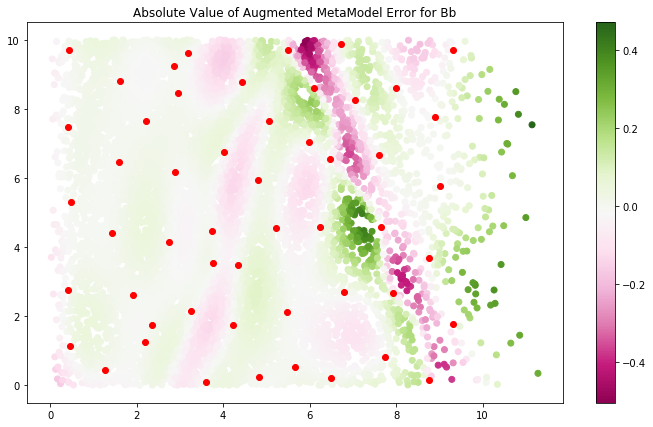

In [53]:
plt.figure(figsize=(12,7))

scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=(testresults_3['Bb'] - testresults_3['BbZ']), 
    cmap='PiYG',
)
plt.colorbar(scat)

plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    #c=aug_mm[3].function.output_sample.Bb,
    color='red',
)
plt.title("Absolute Value of Augmented MetaModel Error for Bb");

In [54]:
testresults_3[['std_Aa', 'std_Bb']] = testresults_3[['x1','x2']].apply(
    lambda x: pandas.Series(aug_mm[3].function.compute_std(**x)), 
    axis=1,
)

In [55]:
testresults_3['std_Bb'] = testresults_3[['x1','x2']].apply(
    lambda x: aug_mm[3].function.compute_std(**x)['Bb'], 
    axis=1,
)

In [56]:
zzz= testresults_3[['x1','x2']].head().copy()

In [57]:
zzz.apply(
    lambda x: pandas.Series(aug_mm[3].function.compute_std(**x)), 
    axis=1,
)

,Aa,Bb
0,0.046580,0.016142
1,0.333107,0.070372
2,0.088718,0.044742
3,0.213574,0.037003
4,0.116505,0.030401


In [58]:
zzz

,x1,x2
0,2.417055,1.302828
1,0.862176,1.589445
2,7.900325,6.559052
3,0.736626,5.090140
4,3.283173,6.701449


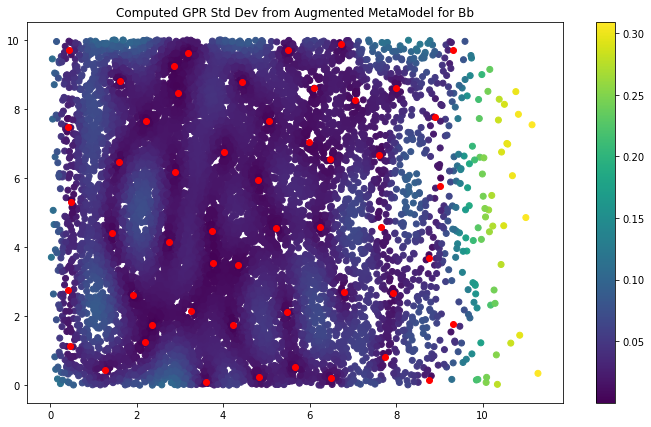

In [59]:
plt.figure(figsize=(12,7))

scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=testresults_3['std_Bb'], 
    cmap='viridis',
)
plt.colorbar(scat)

plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    #c=aug_mm[3].function.output_sample.Bb,
    color='red',
)

plt.title("Computed GPR Std Dev from Augmented MetaModel for Bb");

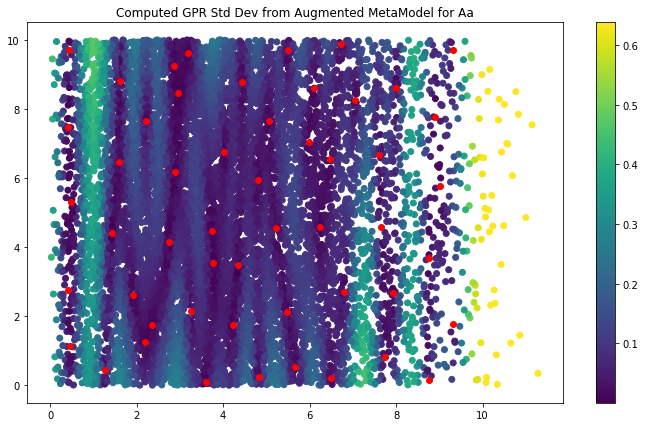

In [60]:
plt.figure(figsize=(12,7))

scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=testresults_3['std_Aa'], 
    cmap='viridis',
)
plt.colorbar(scat)

plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    color='red',
)


plt.title("Computed GPR Std Dev from Augmented MetaModel for Aa");

In [61]:
testresults_3['std_Aa'].min()

0.00021930753194562388

In [62]:
ma = aug_mm[3]
# ma = m.create_metamodel_from_designs(design_names)

In [63]:
X = numpy.asarray([5.97821617,7.03668209]).reshape(1, -1)

In [64]:
ma.function.regression.step1.estimators_[1].kernel_

RBF(length_scale=[0.898, 2.16])

In [65]:
gaussian = ma.function.regression.step1.estimators_[1].predict(X) * ma.function.regression.standardize_Y[None, 1]

In [66]:
detrend = ma.function.regression.detrend_predict(X)['Bb'].values
detrend, gaussian, detrend+gaussian

(array([0.92613587]), array([-0.11262879]), array([0.81350708]))

In [67]:
ma.function(x1=X[0,0],x2=X[0,1])

{'Aa': 5.693239520045409, 'Bb': 0.8135070833961884}

In [68]:
ma2 = ma.function.regression.step1.estimators_[1]

In [69]:
import sklearn
ma3 = sklearn.base.clone(ma.function.regression.step1.estimators_[1], safe=True)

In [70]:
from copy import deepcopy
ma3 = deepcopy(ma.function.regression.step1.estimators_[1])

In [71]:
ma2_X = ma2.X_train_.copy()
ma2_y = ma2.y_train_.copy()
ma2_a = ma2.alpha_.copy()

In [72]:
# if 1:
#     ma2.X_train_ = ma2_X
#     ma2.y_train_ = ma2_y 
#     ma2.alpha_   = ma2_a 

In [73]:
ma3.X_train_ = numpy.delete(ma3.X_train_, 1, 0)

ma3.y_train_ = numpy.delete(ma3.y_train_, 1, 0)

ma3.alpha_ =  numpy.delete(ma3.alpha_, 1, 0)

In [74]:
ma2.alpha_

array([ 0.50128127, -2.199774  , -7.69807748, -5.38340377, -0.68288103,
       -2.65060819,  3.59668188, -6.17977333,  4.67006297, -0.08748699,
        8.05974539,  0.91976436, -2.21995757,  1.55249154, -2.06662327,
       -2.2983096 ,  3.56716694, -7.6692752 ,  9.6271117 , -5.3112567 ,
       -2.10268216, -0.19112883,  0.73006977,  3.29460647,  2.88441489,
        0.17431395,  0.80728827, -0.82605005, -0.26681697, -2.40537317,
       -0.02760385, -3.00880817, -0.40701806,  0.15855437,  3.00744485,
       -0.54341285,  2.01269596, -0.06994217, -0.60696749,  5.65206685,
        3.91591048,  1.69703663, -2.13781699, -4.64124249,  5.12287339,
       -2.9112884 ,  0.59419044,  1.47025174, -2.38043537,  0.43854994,
        1.11828146,  1.88865641])

In [75]:
ma3.alpha_

array([ 0.50128127, -7.69807748, -5.38340377, -0.68288103, -2.65060819,
        3.59668188, -6.17977333,  4.67006297, -0.08748699,  8.05974539,
        0.91976436, -2.21995757,  1.55249154, -2.06662327, -2.2983096 ,
        3.56716694, -7.6692752 ,  9.6271117 , -5.3112567 , -2.10268216,
       -0.19112883,  0.73006977,  3.29460647,  2.88441489,  0.17431395,
        0.80728827, -0.82605005, -0.26681697, -2.40537317, -0.02760385,
       -3.00880817, -0.40701806,  0.15855437,  3.00744485, -0.54341285,
        2.01269596, -0.06994217, -0.60696749,  5.65206685,  3.91591048,
        1.69703663, -2.13781699, -4.64124249,  5.12287339, -2.9112884 ,
        0.59419044,  1.47025174, -2.38043537,  0.43854994,  1.11828146,
        1.88865641])

In [76]:
ma3.predict(X) * ma.function.regression.standardize_Y[None, 1]

array([0.56962393])

In [77]:
ma.function.regression.step1.estimators_[1].predict(X) * ma.function.regression.standardize_Y[None, 1]

array([-0.11262879])

In [78]:

ma.function.regression.predict(X)

,Aa,Bb
0,5.69324,0.813507


In [79]:
ma.function.regression.detrend_predict(X)

,Aa,Bb
0,6.135675,0.926136


In [80]:
ma.function.regression.residual_predict(X)

,Aa,Bb
0,-0.442436,-0.112629


In [81]:
pandas.Series({'x1':7,'x2':7})

x1    7
x2    7
dtype: int64

In [82]:
ma.function.preprocess_raw_input(pandas.Series({'x1':7,'x2':7}))

x1    7
x2    7
dtype: int64

In [83]:
ma.function.input_sample

,x1,x2
experiment,,
1,1.924869,2.611062
2,5.978216,7.036682
3,2.867495,9.234619
4,3.773829,3.548086
5,1.590173,6.451685
6,5.220641,4.559745
7,2.193670,1.262400
8,6.463013,6.541812
9,2.958569,8.458431


In [84]:

def leave_one_out_prediction(metamodel):
    
    from copy import deepcopy
    
    n_rows = len(metamodel.input_sample)
    result = {}
    
    for i in range(n_rows):
        meat = deepcopy(metamodel)
        for e in meat.regression.step1.estimators_:
            pass
            e.X_train_ = numpy.delete(e.X_train_, i, 0)
            e.y_train_ = numpy.delete(e.y_train_, i, 0)
            e.alpha_ =  numpy.delete(e.alpha_, i, 0)
        result[i] = meat(**metamodel.input_sample.iloc[i])
    return result

In [85]:
leave_one_out_prediction(ma.function)

{0: {'Aa': 4.2152152202585125, 'Bb': -0.15535580910995564},
 1: {'Aa': 4.473706088769015, 'Bb': 1.495759794985467},
 2: {'Aa': 14.677579783466825, 'Bb': 2.3875517894409084},
 3: {'Aa': 6.529522295650418, 'Bb': 1.953789602876077},
 4: {'Aa': 5.241796106443207, 'Bb': 0.21179679794497516},
 5: {'Aa': 1.5913461828896898, 'Bb': 1.6295644814092647},
 6: {'Aa': -3.0629720625820087, 'Bb': -1.110976795079281},
 7: {'Aa': 7.36606440983912, 'Bb': 2.7861192265907535},
 8: {'Aa': -28.595986677867444, 'Bb': -1.4483122246980997},
 9: {'Aa': 2.6919217552665438, 'Bb': 0.02732780870970064},
 10: {'Aa': 7.806877859710549, 'Bb': -1.6818931047649817},
 11: {'Aa': 4.473502165869334, 'Bb': -0.2852618784204917},
 12: {'Aa': 12.141559483990264, 'Bb': 2.291211353697592},
 13: {'Aa': 7.822250176128042, 'Bb': -0.23135461704300608},
 14: {'Aa': -1.2854582928176645, 'Bb': 0.8687386277562544},
 15: {'Aa': 5.859779690480468, 'Bb': 1.1959745470976482},
 16: {'Aa': 10.685248189465923, 'Bb': -1.1062798496557598},
 17: {

In [86]:
cv0_predict = ma.function.cross_val_predicts(cv=0)

In [87]:
cv0_predict

,Aa,Bb
experiment,,
1,3.219191,-0.007378
2,5.598403,0.845783
3,3.460729,0.058710
4,3.306755,0.301392
5,2.757560,0.022944
6,4.277000,0.860181
7,2.822072,-0.009344
8,6.580213,0.965038
9,3.113536,-0.056913


In [88]:
cv0_error = ma.function.output_sample - cv0_predict

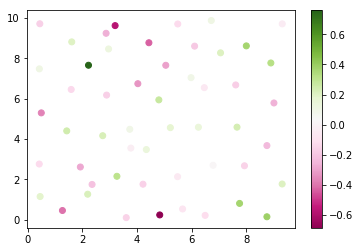

In [89]:
scat = plt.scatter(
    ma.function.input_sample.x1, 
    ma.function.input_sample.x2, 
    c=cv0_error.Aa,
    cmap='PiYG'
)
plt.colorbar(scat)

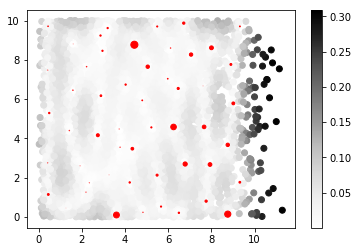

In [90]:
scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=testresults_3['std_Bb'], 
    cmap='Greys',
)
plt.colorbar(scat)

scat = plt.scatter(
    ma.function.input_sample.x1, 
    ma.function.input_sample.x2, 
    500*cv0_error.Bb**2,
    color='red'
)
